Calculate the Bayes Factor for the stellar mass to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
#from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '/home/codebind/Bootes/NSA_Full.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]
del data

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]
del catalog_SDSS

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]
del catalog_north

In [5]:
print(catalog_main[0])

      IAUNAME                  SUBDIR                   RA                DEC         ISDSS INED ISIXDF IALFALFA IZCAT ITWODF    MAG        Z      ZSRC    SIZE    RUN  CAMCOL FIELD RERUN    XPOS      YPOS   NSAID   ZDIST         SERSIC_NMGY           SERSIC_NMGY_IVAR    SERSIC_OK      SERSIC_RNMGY           SERSIC_ABSMAG           SERSIC_AMIVAR            EXTINCTION              SERSIC_KCORRECT               SERSIC_KCOEFF                SERSIC_MTOL          SERSIC_B300  SERSIC_B1000 SERSIC_METS  SERSIC_MASS         XCEN              YCEN         NPROF        PROFMEAN       PROFMEAN_IVAR           QSTOKES                  USTOKES                  BASTOKES              PHISTOKES              PETRO_FLUX          PETRO_FLUX_IVAR             FIBER_FLUX          FIBER_FLUX_IVAR     PETRO_BA50 PETRO_PHI50 PETRO_BA90 PETRO_PHI90      SERSIC_FLUX          SERSIC_FLUX_IVAR     SERSIC_N SERSIC_BA  SERSIC_PHI           ASYMMETRY                     CLUMPY          DFLAGS AID PID DVERSION      PROF

In [6]:
Mstar_NSA = np.array(catalog_main['ELPETRO_MASS'])
del catalog_main

### Kirshner Data

In [7]:
KNSA = Table.read('/home/codebind/Bootes/My Code/KNSA.txt', format = "ascii.commented_header")
KNSAM = KNSA['MASS']

# Fit the $M_*$ distributions with skewnormal distributions

Both one- and two-parent models

In [8]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

In [9]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                    'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
               '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$', 
               '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
               '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$']

This is a unimodal distribution

In [11]:
#Mstar_bins = np.linspace(5.9, 12, 135)
Mstar_bins = np.linspace(8, 12, 100)
k_bins = np.linspace(8, 12, 50)

## 1-parent model

In [12]:
'''
Mstar_fit_bounds1 = [[0.001, 10],   # s ...... Gaussian 1 to 2 scale factor
                     [1000, 50000], # a ...... Gaussian amplitude
                     [10, 11],      # mu ..... Gaussian location
                     [0.5, 1],      # sigma .. Gaussian scale
                     [-5, 0]]       # skew ... Gaussian skew
'''
Mstar_fit_bounds1 = [[0.1, 10],    # s ........ Gaussian 1 to 2 scale factor
                     [10, 10000],  # a ........ Gaussian a amplitude
                     [8, 10.45],   # mu_a ..... Gaussian a location
                     [1e-5, 2],    # sigma_a .. Gaussian a scale
                     [-5, 5],      # skew_a ... Gaussian a skew
                     [500, 50000], # b ........ Gaussian b amplitude
                     [10.45, 11],  # mu_b ..... Gaussian b location
                     [1e-5, 2],    # sigma_b .. Gaussian b scale
                     [-5, 5]]      # skew_b ... Gaussian b skew

V2_Mstar_bestfit1 = Model_1_fit(Mstar_fit_bounds1, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                2, 
                                #p0=[2.29, 4640, 10.54, 0.73, -2.93]
                               )

V2_Mstar_bestfit1

running minimizer...this might take a few minutes...


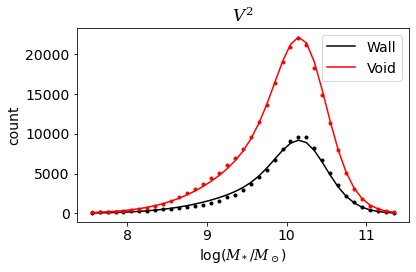

In [14]:
Model_1_plot(V2_Mstar_bestfit1.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

In [16]:
Mstar_fit_bounds1 = [[0.1, 10],    # s ........ Gaussian 1 to 2 scale factor
                     [10, 10000],  # a ........ Gaussian a amplitude
                     [8, 10.45],   # mu_a ..... Gaussian a location
                     [1e-5, 2],    # sigma_a .. Gaussian a scale
                     [-5, 5],      # skew_a ... Gaussian a skew
                     [500, 50000], # b ........ Gaussian b amplitude
                     [10.45, 11],  # mu_b ..... Gaussian b location
                     [1e-5, 2],    # sigma_b .. Gaussian b scale
                     [-5, 5]]      # skew_b ... Gaussian b skew

VF_Mstar_bestfit1 = Model_1_fit(Mstar_fit_bounds1, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                2, 
                                #p0=[0.36, 10645, 10.5, 0.74, -2.97]
                               )

VF_Mstar_bestfit1

running minimizer...this might take a few minutes...


      fun: 4215.619940685453
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.19963409,  0.01054929,  1.35569269,  2.0859261 ,  0.37089194,
       -0.01018552, -1.82953939,  3.12111295, -0.07021299])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1320
      nit: 91
     njev: 132
   status: 0
  success: True
        x: array([ 3.55210674e-01,  9.79264422e+03,  1.03554797e+01,  3.55934047e-01,
       -8.47361466e-01,  1.45277094e+04,  1.04618815e+01,  9.24381234e-01,
       -2.23170889e+00])

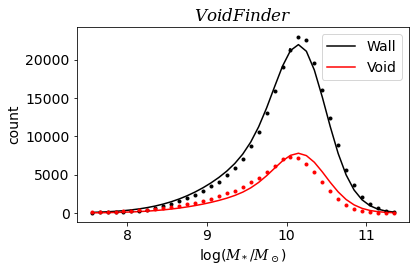

In [17]:
Model_1_plot(VF_Mstar_bestfit1.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             np.arange(7.5, 11.5, 0.1), 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$VoidFinder$')

### Nested sampling of Likelihood and Priors

In [18]:
def prior_xform1_uni_V2(u):
    '''
    Priors for the 5 parameters of unimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    '''
    s = uniform(0.1, 5, u[0])
    a = jeffreys(1000, 50000, u[1])
    mu = uniform(9, 11, u[2])
    sigma = uniform(0.01, 2, u[3])
    skew = uniform(-5, 5, u[4])

    return s, a, mu, sigma, skew
    '''
    
    s = uniform(1, 4, u[0])
    
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(9.5, 10.45, u[2])
    sigma_a = uniform(0.1, 2, u[3])
    skew_a = uniform(-4, 0, u[4])
    
    b = jeffreys(1000, 10000, u[5])
    mu_b = uniform(10.45, 11, u[6])
    sigma_b = uniform(0.1, 2, u[7])
    skew_b = uniform(-4, 0, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [36]:
Model_1_sampler(prior_xform1_uni_V2, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                2, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


36374it [31:30, 19.24it/s, batch: 7 | bound: 1895 | nc: 10 | ncall: 1662209 | eff(%):  2.188 | loglstar: -952.752 < -943.722 < -945.316 | logz: -983.441 +/-  0.370 | stop:  0.982]           


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_Mstar_V2'


In [12]:
#temp_infile = open('dynesty_output/sampler_results_model1_gauss_Mstar_V2.pickle', 'rb')
temp_infile = open('dynesty_output/sampler_results_model1_Mstar_V2.pickle', 'rb')
dres1_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

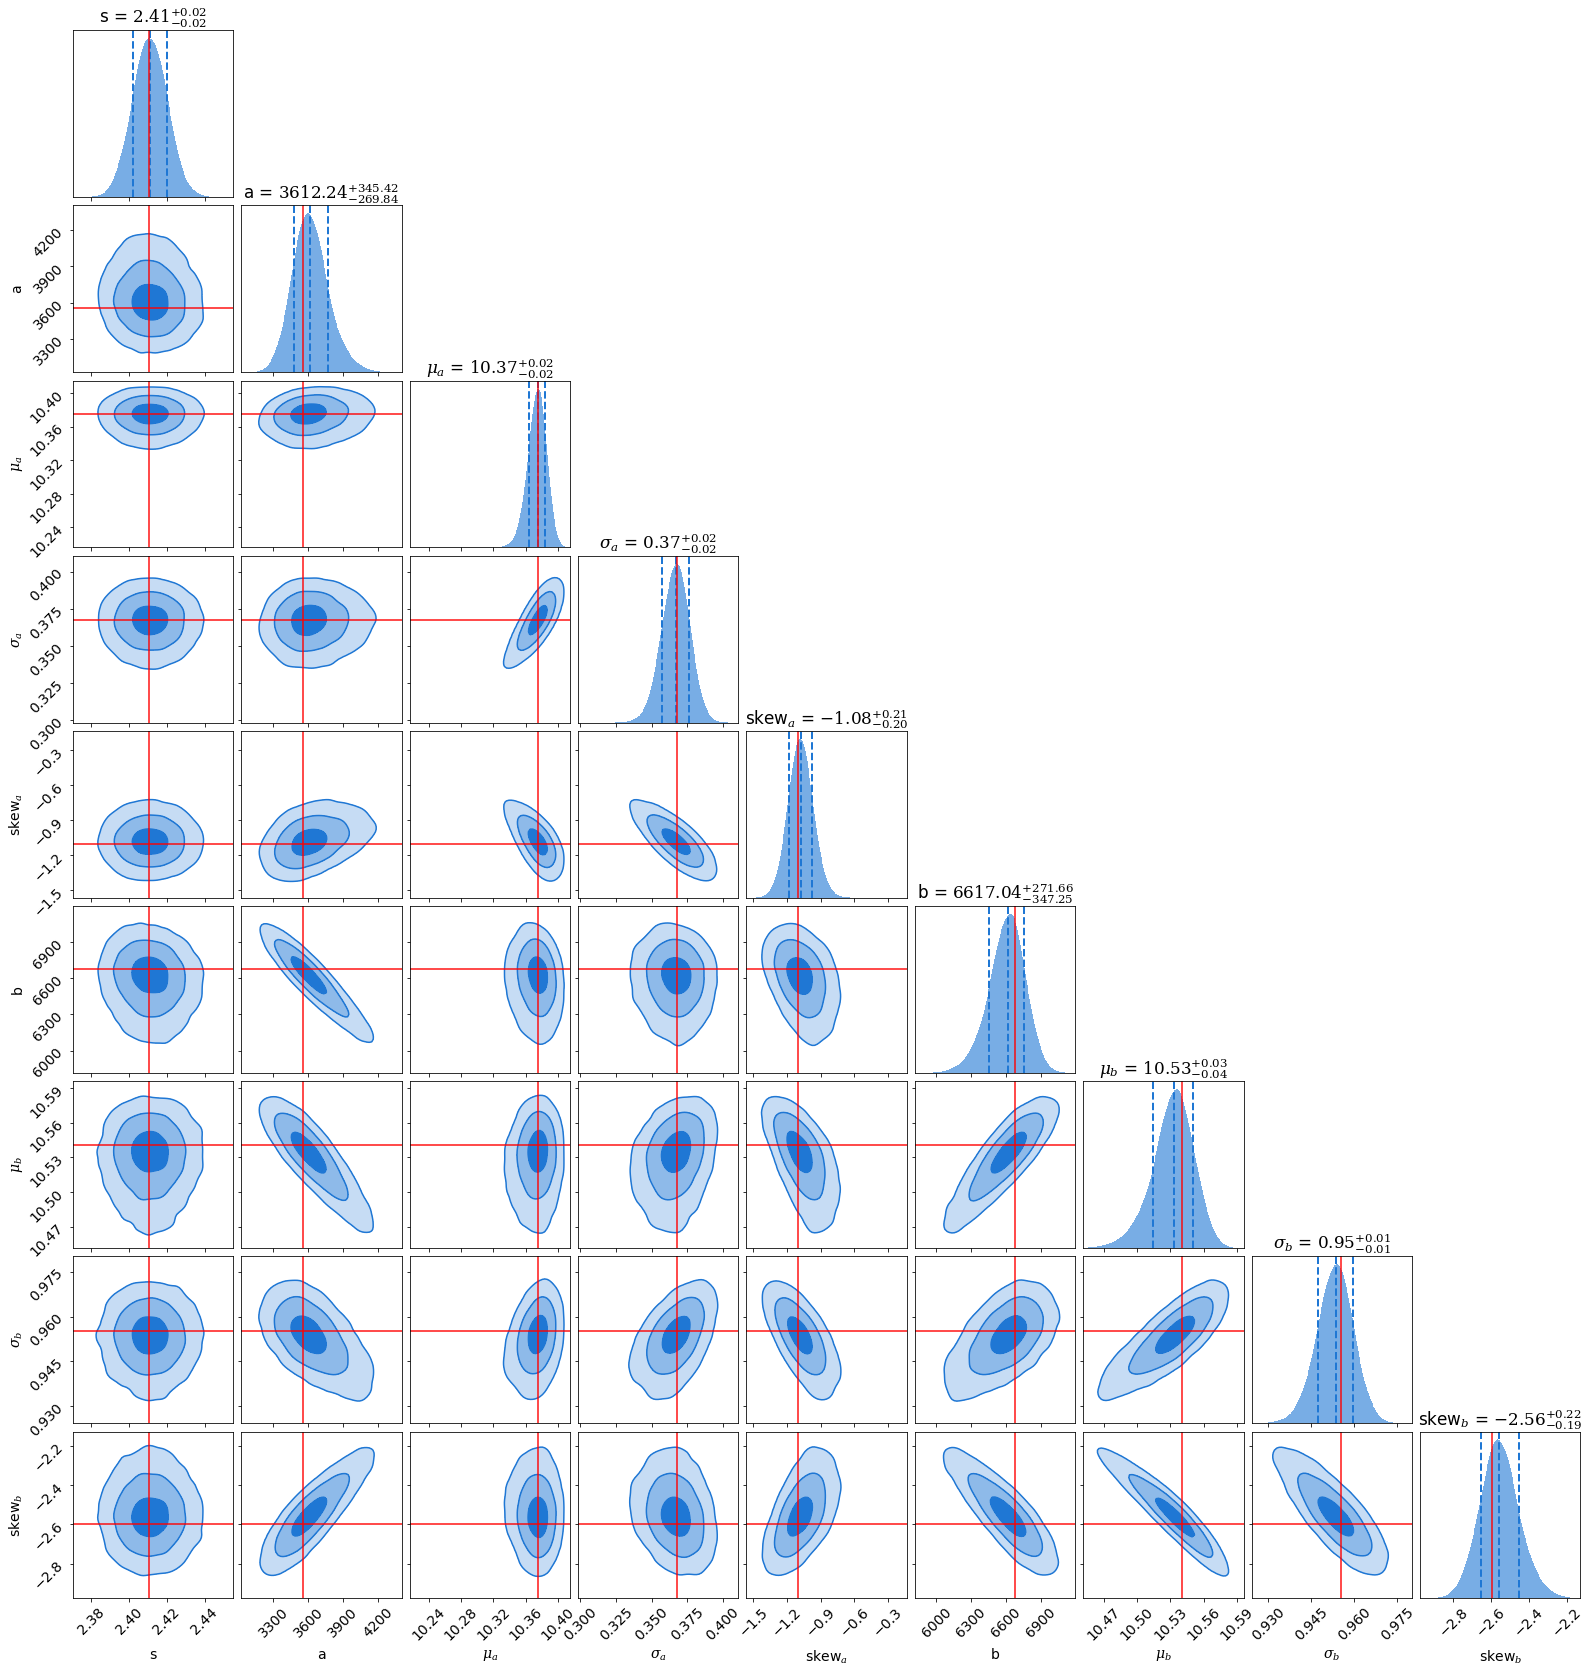

In [21]:
fig, axes = dyplot.cornerplot(dres1_V2_Mstar, smooth=0.03, 
                              labels=labels1_bi, 
                              #labels=labels1_uni, 
                              truths=V2_Mstar_bestfit1.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(9, 9, figsize=(2.5*9, 2.6*9)), 
                              #fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

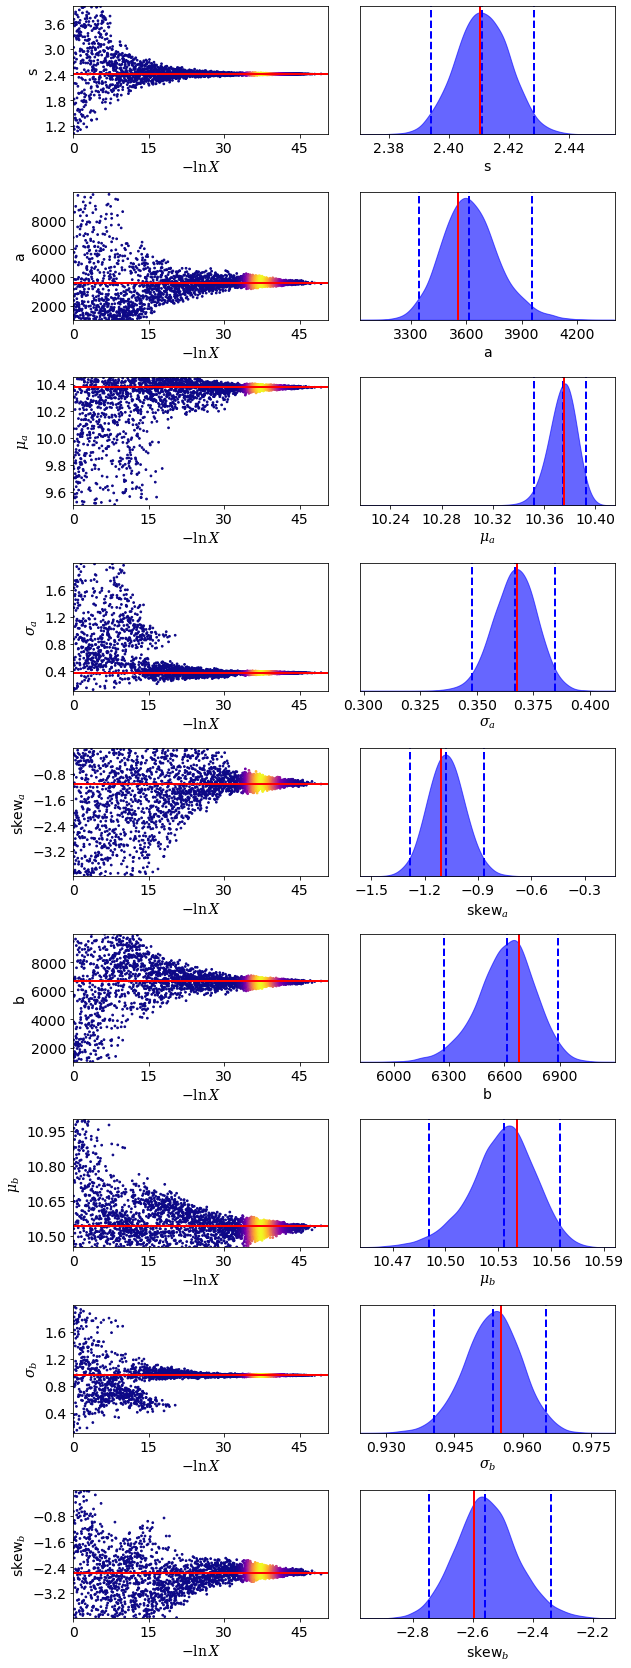

In [22]:
n_params = len(labels1_bi)

fig, axes = dyplot.traceplot(dres1_V2_Mstar, 
                             labels=labels1_bi, 
                             truths=V2_Mstar_bestfit1.x, 
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [13]:
lnzM1_V2_Mstar = dres1_V2_Mstar.logz[-1]
lnzM1_V2_Mstar

-983.4425607452994

In [24]:
V2_Mstar_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_V2_Mstar.samples, 
                                                  np.exp(dres1_V2_Mstar.logwt - lnzM1_V2_Mstar))

V2_Mstar_bestfit1_dynesty

array([ 2.41120686e+00,  3.62181897e+03,  1.03742424e+01,  3.66836463e-01,
       -1.07866622e+00,  6.60718576e+03,  1.05321048e+01,  9.53350338e-01,
       -2.55419447e+00])

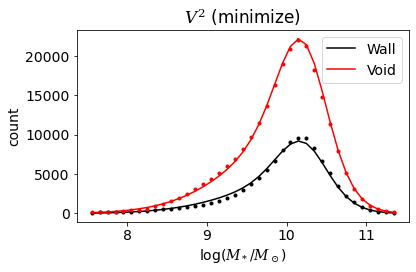

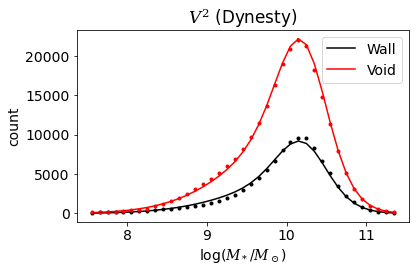

In [25]:
Model_1_plot(V2_Mstar_bestfit1.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (minimize)')

Model_1_plot(V2_Mstar_bestfit1_dynesty, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (Dynesty)')

In [26]:
def prior_xform1_uni_VF(u):
    '''
    Priors for the 5 parameters of unimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''
    
    '''
    s = uniform(0.1, 1, u[0])
    a = jeffreys(8000, 50000, u[1])
    mu = uniform(9, 11, u[2])
    sigma = uniform(0.01, 2, u[3])
    skew = uniform(-5, 5, u[4])

    return s, a, mu, sigma, skew
    '''
    
    s = uniform(0.01, 2, u[0])
    
    a = jeffreys(1000, 10000, u[1])
    mu_a = uniform(9.5, 10.45, u[2])
    sigma_a = uniform(0.1, 2, u[3])
    skew_a = uniform(-4, 0, u[4])
    
    b = jeffreys(5000, 50000, u[5])
    mu_b = uniform(10.45, 11, u[6])
    sigma_b = uniform(0.1, 2, u[7])
    skew_b = uniform(-4, 0, u[8])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [41]:
Model_1_sampler(prior_xform1_uni_VF, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                2, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


36219it [29:57, 20.15it/s, batch: 7 | bound: 1404 | nc: 30 | ncall: 1149975 | eff(%):  3.150 | loglstar: -4221.866 < -4213.098 < -4215.966 | logz: -4253.848 +/-  0.376 | stop:  0.947]      


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_Mstar_VoidFinder'


In [14]:
temp_infile = open('dynesty_output/sampler_results_model1_Mstar_VoidFinder.pickle', 
#temp_infile = open('dynesty_output/sampler_results_model1_gauss_Mstar_VoidFinder.pickle', 
                   'rb')
dres1_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

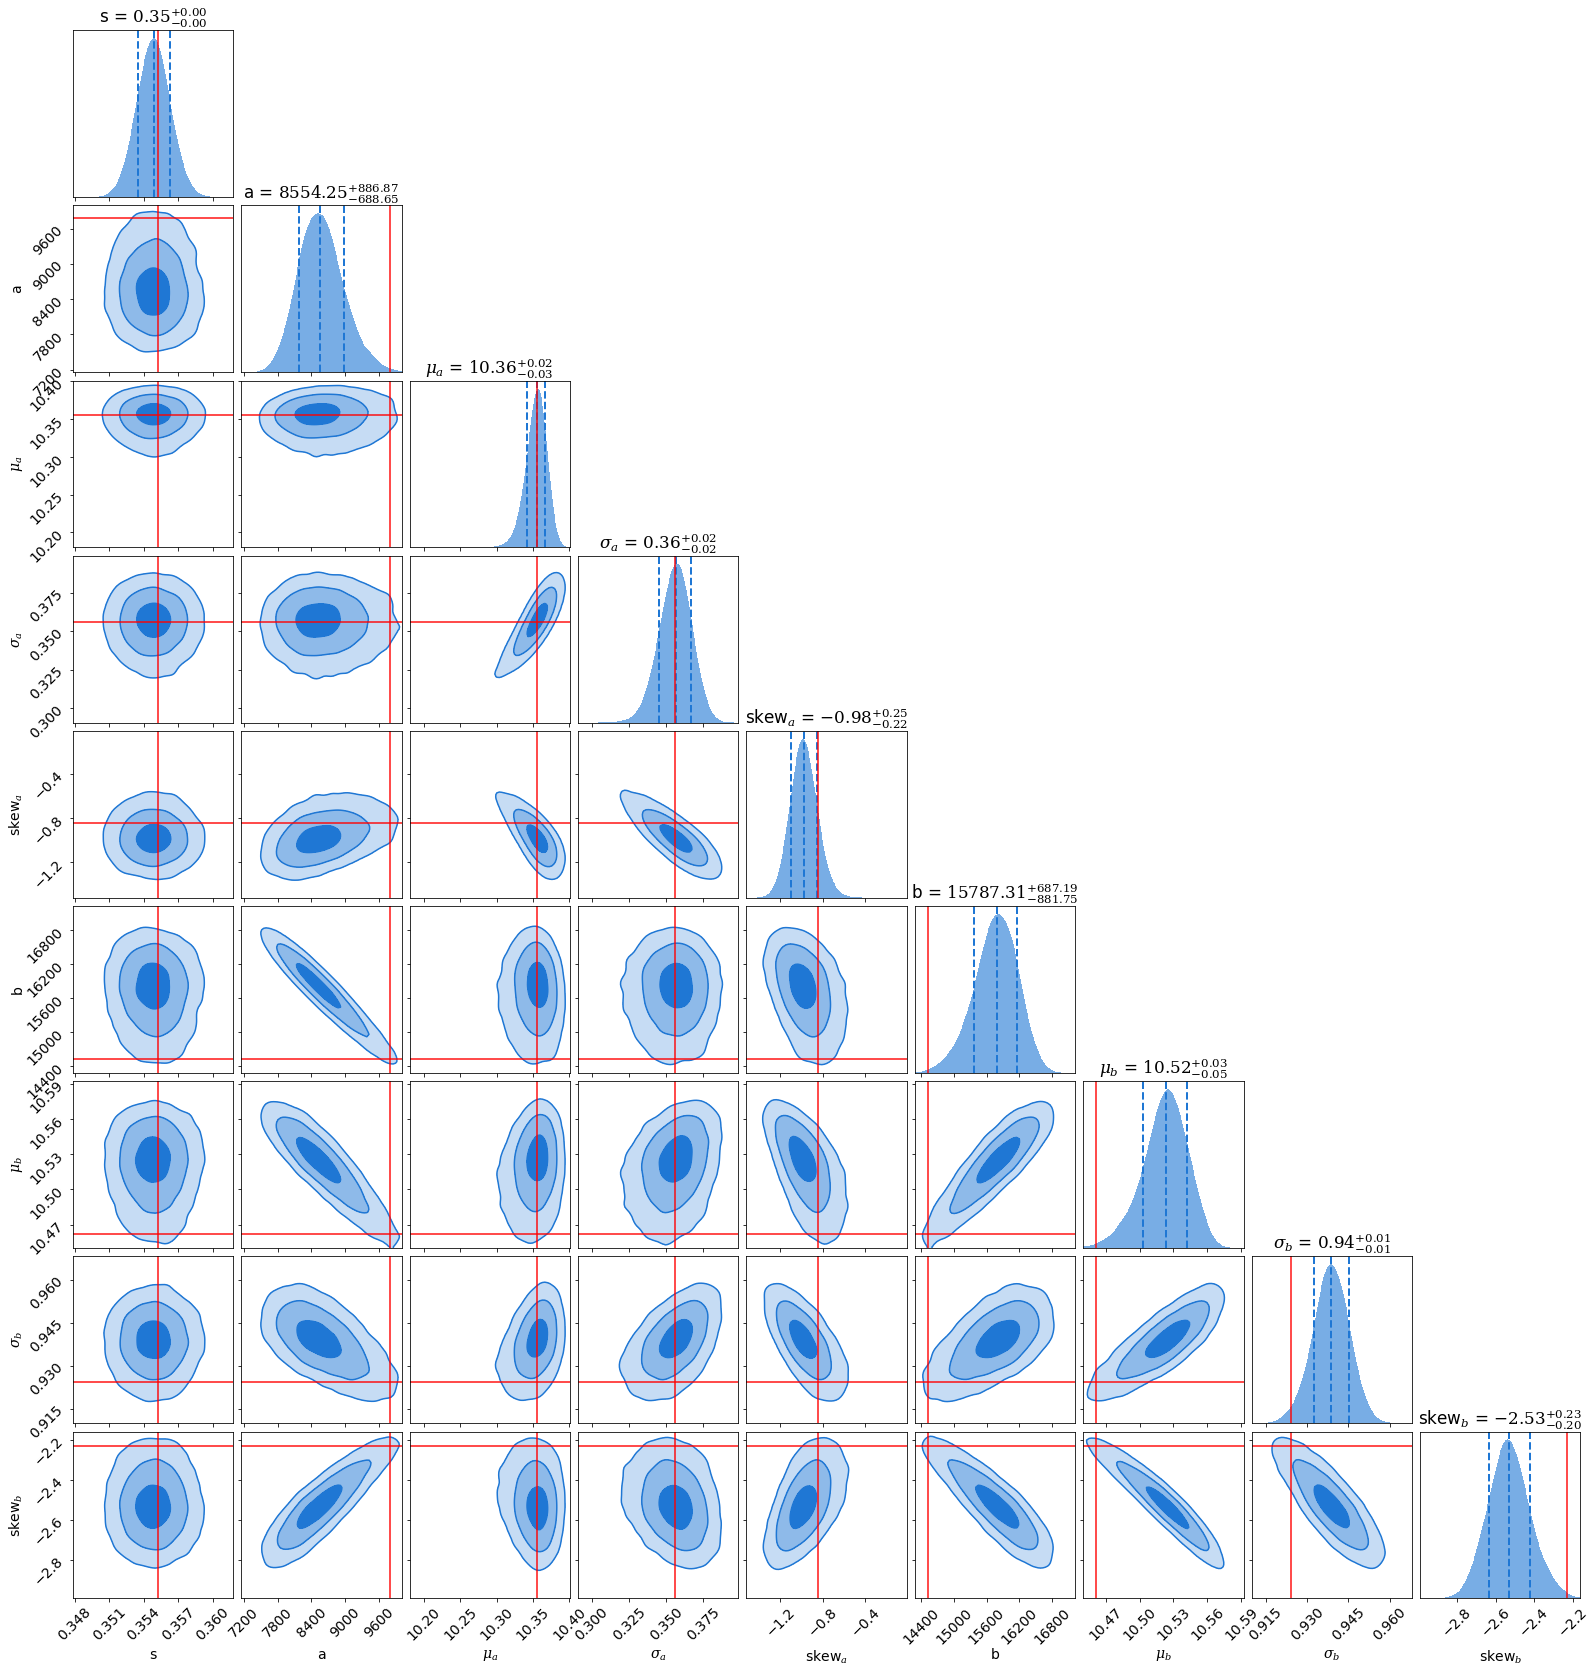

In [28]:
fig, axes = dyplot.cornerplot(dres1_VF_Mstar, smooth=0.03, 
                              labels=labels1_bi, 
                              #labels=labels1_uni, 
                              truths=VF_Mstar_bestfit1.x, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(9, 9, figsize=(2.5*9, 2.6*9)), 
                              #fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

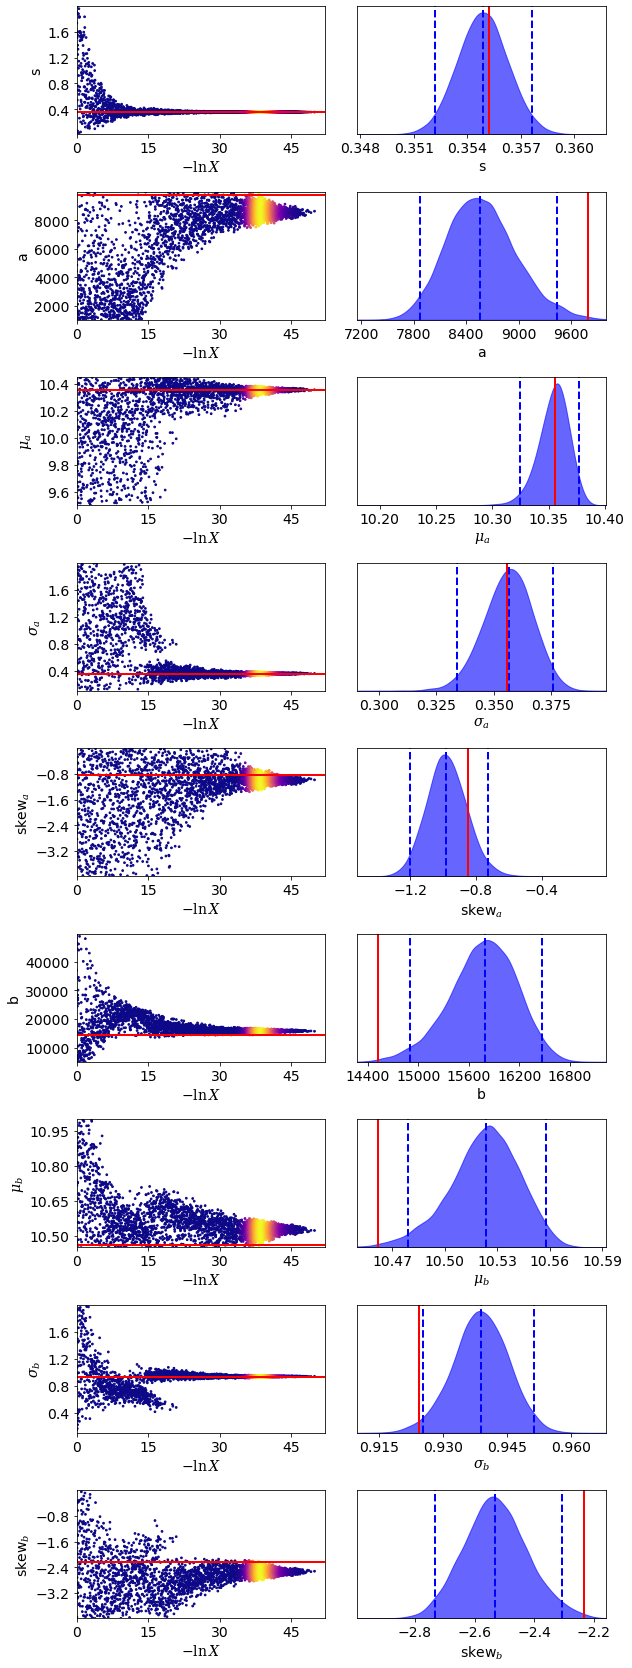

In [29]:
n_params = len(labels1_bi)

fig, axes = dyplot.traceplot(dres1_VF_Mstar, 
                             labels=labels1_bi, 
                             truths=VF_Mstar_bestfit1.x, 
                             fig=plt.subplots(n_params, 2, figsize=(n_params, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [15]:
lnzM1_VF_Mstar = dres1_VF_Mstar.logz[-1]
lnzM1_VF_Mstar

-4253.842797823419

In [31]:
VF_Mstar_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_VF_Mstar.samples, 
                                                  np.exp(dres1_VF_Mstar.logwt - lnzM1_VF_Mstar))

VF_Mstar_bestfit1_dynesty

array([ 3.54866193e-01,  8.57747499e+03,  1.03542803e+01,  3.56191141e-01,
       -9.77355574e-01,  1.57647538e+04,  1.05224719e+01,  9.38698308e-01,
       -2.52886785e+00])

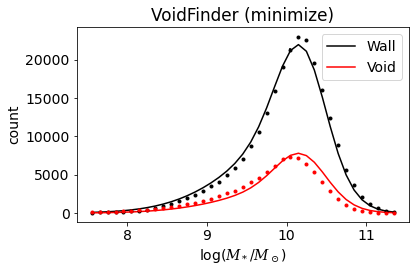

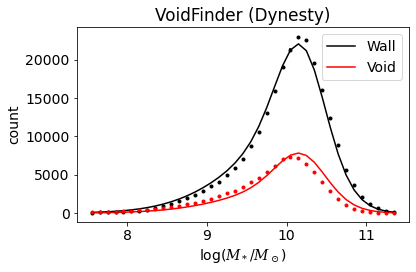

In [32]:
Model_1_plot(VF_Mstar_bestfit1.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (minimize)')

Model_1_plot(VF_Mstar_bestfit1_dynesty, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (Dynesty)')

### 2-parent model

In [33]:
'''
Mstar_fit_bounds2 = [[2000, 50000], # a ........ Gaussian A amplitude
                     [10, 11],      # mu_a ..... Gaussian A location
                     [0.1, 1],      # sigma_a .. Gaussian A scale
                     [-4, -1],      # skew_a ... Gaussian A skew
                     [3000, 50000], # b ........ Gaussian B amplitude
                     [10, 11],      # mu_b ..... Gaussian B location
                     [0.1, 1],      # sigma_b .. Gaussian B scale
                     [-4, -1]]      # skew_b ... Gaussian B skew
'''
# 1 = wall, 2 = void

Mstar_fit_bounds2 = [[10, 50000],  # a1 ........ Gaussian A1 amplitude
                     [8, 10.75],   # mu_a1 ..... Gaussian A1 location
                     [1e-5, 2],    # sigma_a1 .. Gaussian A1 scale
                     [-10, 10],    # skew_a1 ... Gaussian A1 skew
                     [500, 50000], # b1 ........ Gaussian B1 amplitude
                     [10, 11],     # mu_b1 ..... Gaussian B1 location
                     [1e-5, 2],    # sigma_b1 .. Gaussian B1 scale
                     [-10, 5],     # skew_b1 ... Gaussian B1 skew
                     [100, 50000], # a2 ........ Gaussian A2 amplitude
                     [8, 10.5],    # mu_a2 ..... Gaussian A2 location
                     [1e-5, 2],    # sigma_a2 .. Gaussian A2 scale
                     [-10, 10],    # skew_a2 ... Gaussian A2 skew
                     [500, 50000], # b2 ........ Gaussian B2 amplitude
                     [10, 11],     # mu_b2 ..... Gaussian B2 location
                     [1e-5, 2],    # sigma_b2 .. Gaussian B2 scale
                     [-5, 5]]      # skew_b2 ... Gaussian B2 skew

V2_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                2, 
                                #p0=[4640, 10.54, 0.73, -2.91, 10624, 10.54, 0.74, -2.95]
                                #p0=[2300, 9.00, 0.91, 0.68, 8026, 10.47, 0.52, -1.61, 12545, 10.00, 0.39, 0.98, 12272, 10.22, 0.84, -1.70], 
                               )

V2_Mstar_bestfit2

running minimizer...this might take a few minutes...


      fun: 526.1722561904712
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02905866,  0.0764885 ,  0.0120508 , -0.10111307,  0.02432924,
       -0.03753939, -0.03556124,  0.0176442 , -0.08401546, -0.01239186,
       -0.01889475,  0.01946319, -0.03367134, -0.0703153 , -0.17930688,
       -0.0208729 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7820
      nit: 324
     njev: 460
   status: 0
  success: True
        x: array([ 6.34900969e+03,  1.04409954e+01,  4.60008607e-01, -1.43024227e+00,
        3.92799219e+03,  1.04760815e+01,  1.07424609e+00, -2.21325995e+00,
        4.38613379e+03,  1.01456265e+01,  2.33311857e-01,  1.84211114e-02,
        2.01698054e+04,  1.05756463e+01,  9.17259453e-01, -2.92049803e+00])

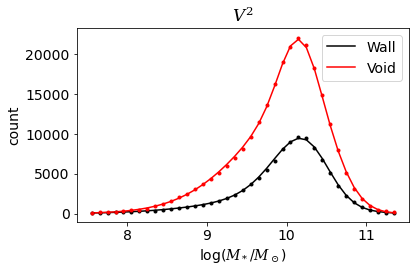

In [34]:
Model_2_plot(V2_Mstar_bestfit2.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

In [26]:
Mstar_fit_bounds2 = [[5000, 30000], # a1 ........ Gaussian A1 amplitude
                     [8, 11],   # mu_a1 ..... Gaussian A1 location
                     [0.01, 2],    # sigma_a1 .. Gaussian A1 scale
                     [-10, 10],    # skew_a1 ... Gaussian A1 skew
                     [5000, 30000], # b1 ........ Gaussian B1 amplitude
                     [8, 11],     # mu_b1 ..... Gaussian B1 location
                     [0.01, 2],    # sigma_b1 .. Gaussian B1 scale
                     [-10, 10],      # skew_b1 ... Gaussian B1 skew
                     [500, 10000],  # a2 ........ Gaussian A2 amplitude
                     [8, 10.5],    # mu_a2 ..... Gaussian A2 location
                     [0.01, 2],    # sigma_a2 .. Gaussian A2 scale
                     [-10, 10],    # skew_a2 ... Gaussian A2 skew
                     [1000, 20000], # b2 ........ Gaussian B2 amplitude
                     [9.5, 11],    # mu_b2 ..... Gaussian B2 location
                     [1e-5, 2],    # sigma_b2 .. Gaussian B2 scale
                     [-5, 5]]      # skew_b2 ... Gaussian B2 skew

VF_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                2, 
                                #p0=[10645, 10.53, 0.68, -2.53, 3808, 10.46, 0.81, -3.41]
                               )

VF_Mstar_bestfit2

running minimizer...this might take a few minutes...


      fun: 453.93878657046264
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.59485267e-02,  9.17753975e+00,  1.11690496e+00, -1.07179404e+00,
       -3.71759891e-02,  9.71442579e+00, -1.11545433e+01,  3.46547040e+00,
       -1.06866758e-03,  2.89450644e+00, -5.36786615e+00, -3.60353172e-01,
       -2.79672578e-03,  1.24517772e+00, -3.14099682e+00,  1.17677246e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7429
      nit: 373
     njev: 437
   status: 0
  success: True
        x: array([ 1.62286293e+04,  1.05518028e+01,  8.87702059e-01, -2.41775096e+00,
        8.01269468e+03,  1.01349176e+01,  2.85276556e-01,  2.38116586e-01,
        3.40791050e+03,  1.03838960e+01,  4.51689172e-01, -1.05103985e+00,
        5.24119247e+03,  1.03779023e+01,  1.01318850e+00, -4.54581823e+00])

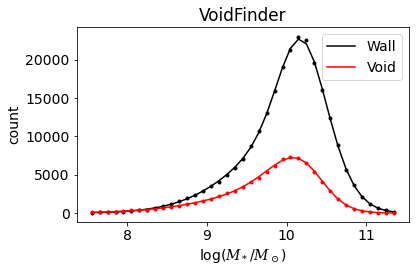

In [27]:
Model_2_plot(VF_Mstar_bestfit2.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder')

### Nested sampling of Likelihood and Priors

#### V$^2$

In [49]:
def prior_xform2_uni_V2(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 10000, u[0])
    mu_a1 = uniform(9, 10.45, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-5, 0, u[3])

    b1 = jeffreys(1000, 10000, u[4])
    mu_b1 = uniform(10.45, 11, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(1000, 10000, u[8])
    mu_a2 = uniform(8, 10.25, u[9])
    sigma_a2 = uniform(0.01, 2, u[10])
    skew_a2 = uniform(-5, 5, u[11])

    b2 = jeffreys(1000, 20000, u[12])
    mu_b2 = uniform(10.25, 11, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 0, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [50]:
Model_2_sampler(prior_xform2_uni_V2, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                2, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


1770it [00:12, 40.60it/s, batch: 0 | bound: 0 | nc: 37 | ncall: 17183 | eff(%): 10.010 | loglstar:   -inf < -102082.871 <    inf | logz: -102093.315 +/-  0.204 | dlogz: 82478.024 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
12772it [04:40, 53.95it/s, batch: 0 | bound: 163 | nc: 25 | ncall: 294996 | eff(%):  4.322 | loglstar:   -inf < -1751.136 <    inf | logz: -1781.913 +/-  0.345 | dlogz: 824.480 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random n

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_V2'


In [16]:
#temp_infile = open('dynesty_output/sampler_results_model2_gauss_Mstar_V2.pickle', 'rb')
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_V2.pickle', 'rb')
dres2_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

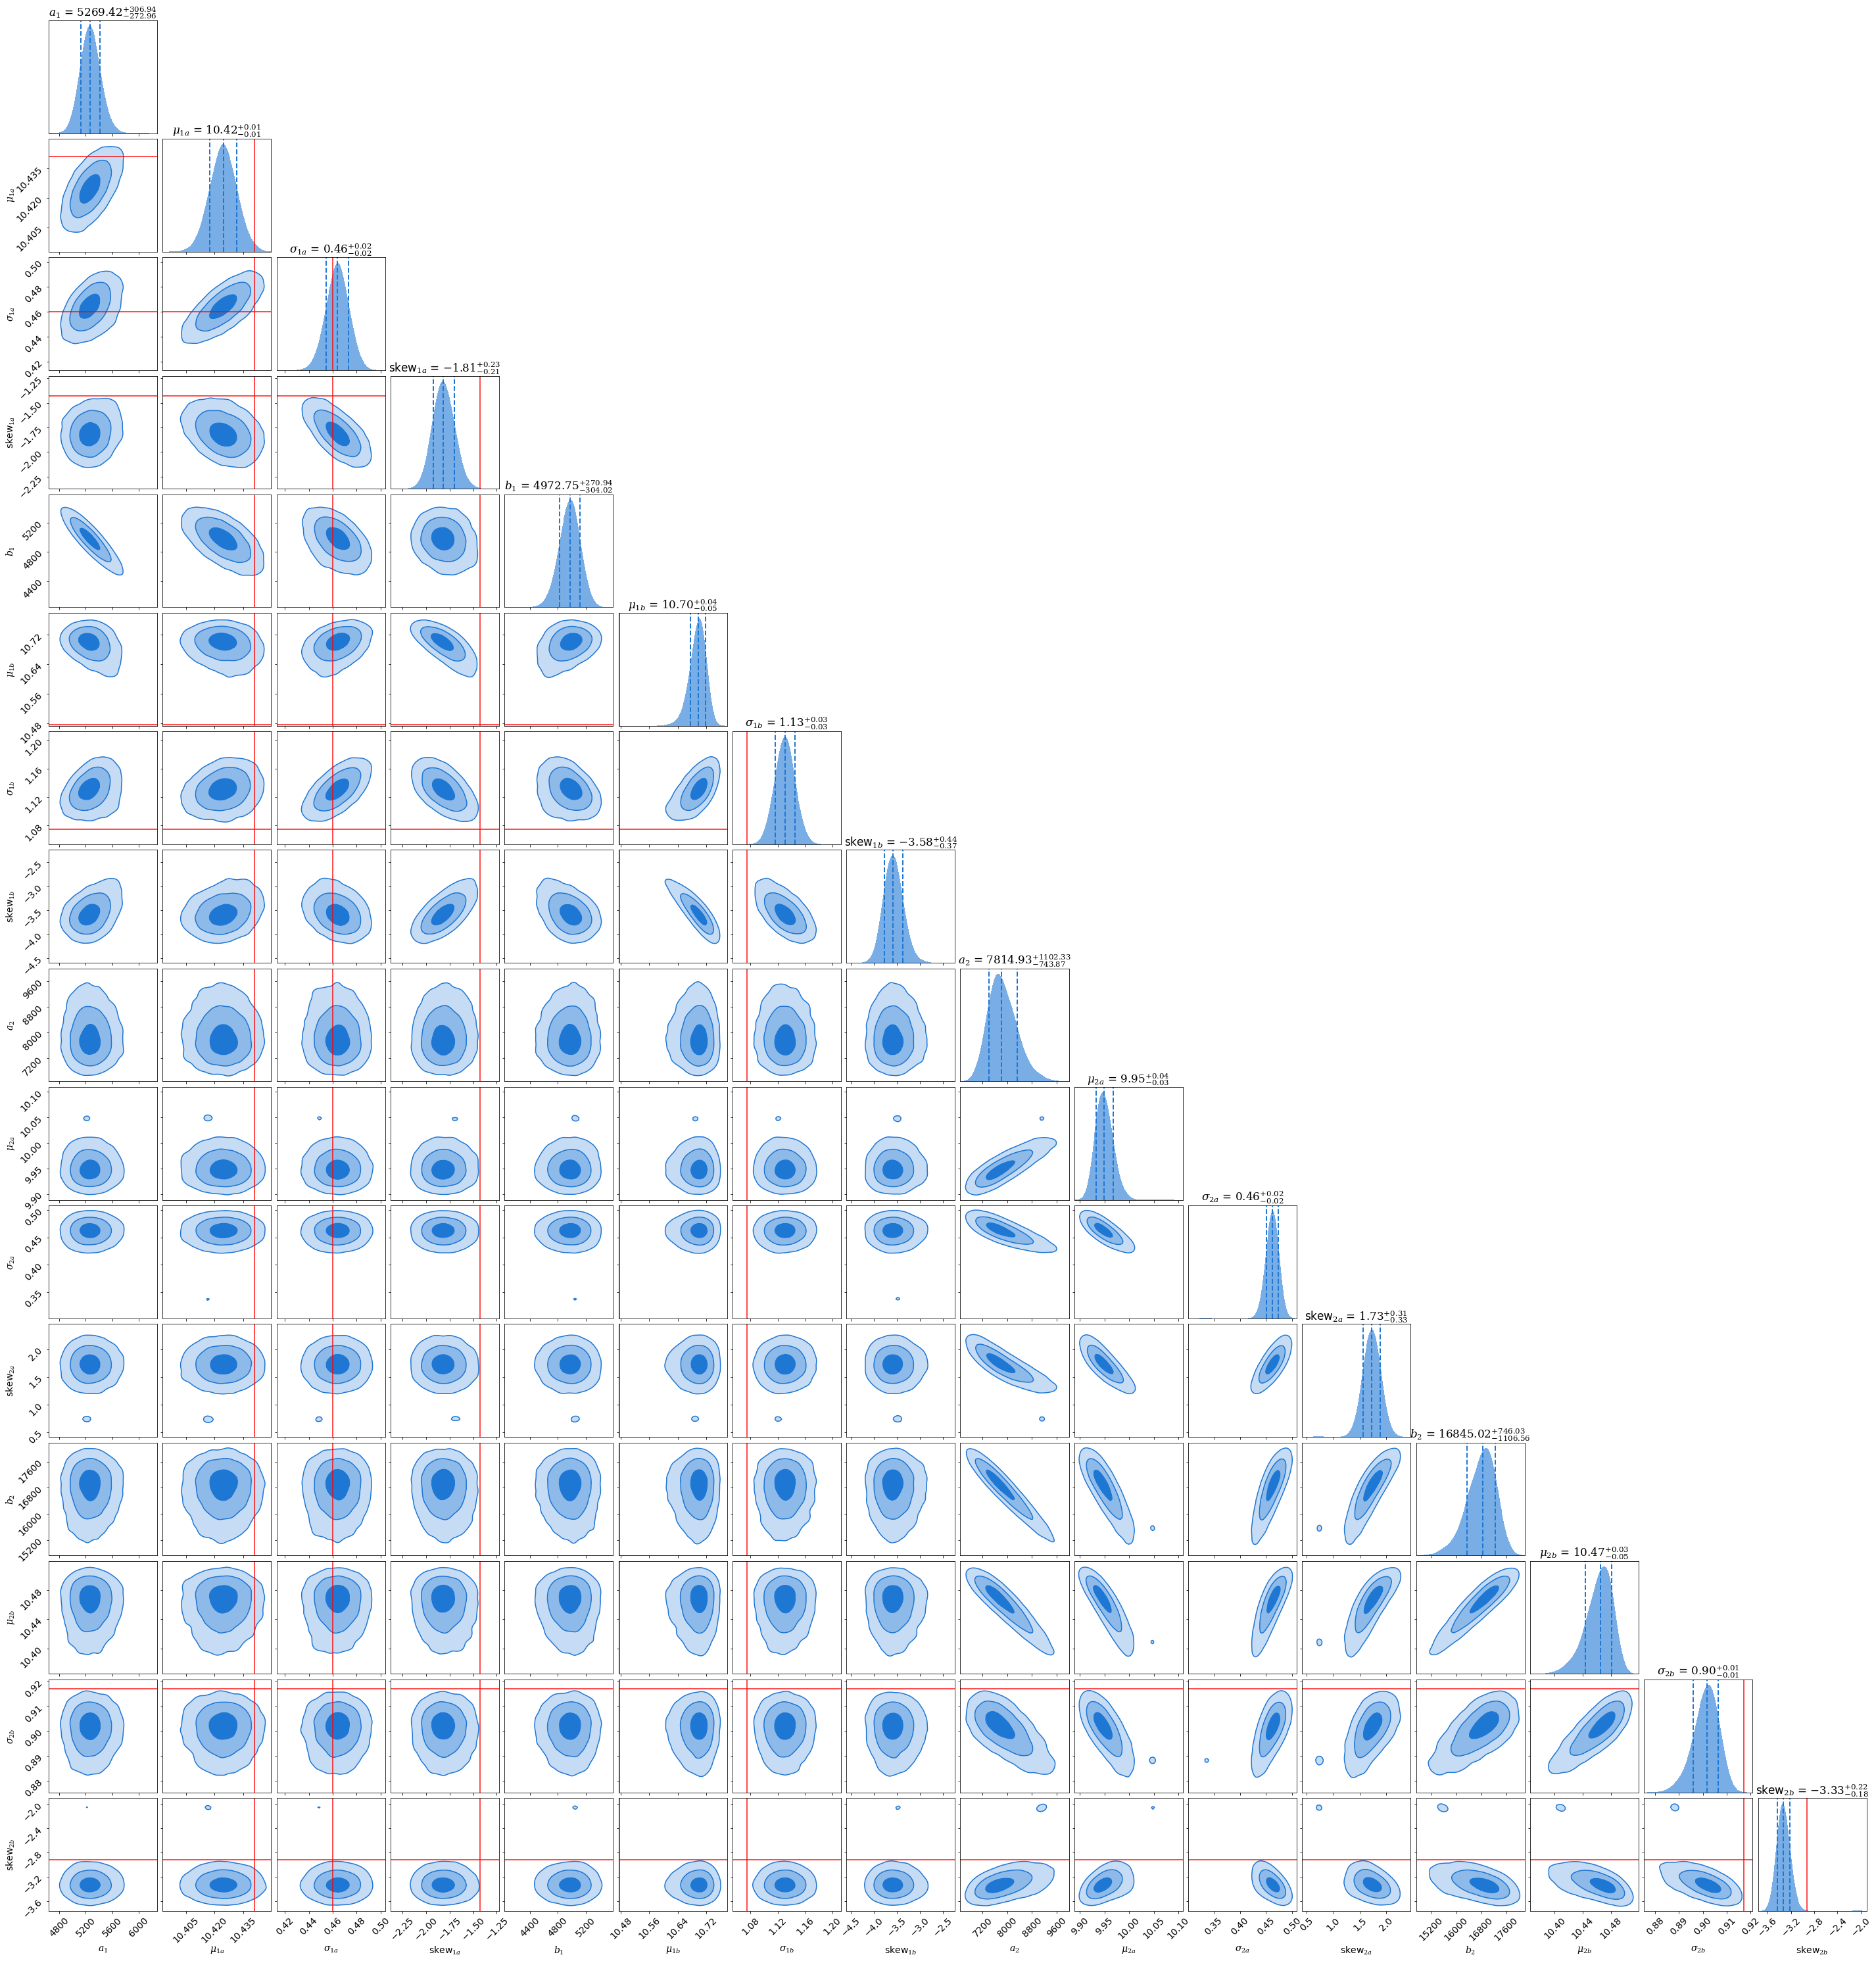

In [52]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_V2_Mstar, smooth=0.03, 
                              labels=labels2_bi, 
                              #labels=labels2_uni, 
                              show_titles=True, 
                              truths=V2_Mstar_bestfit2.x,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              #fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

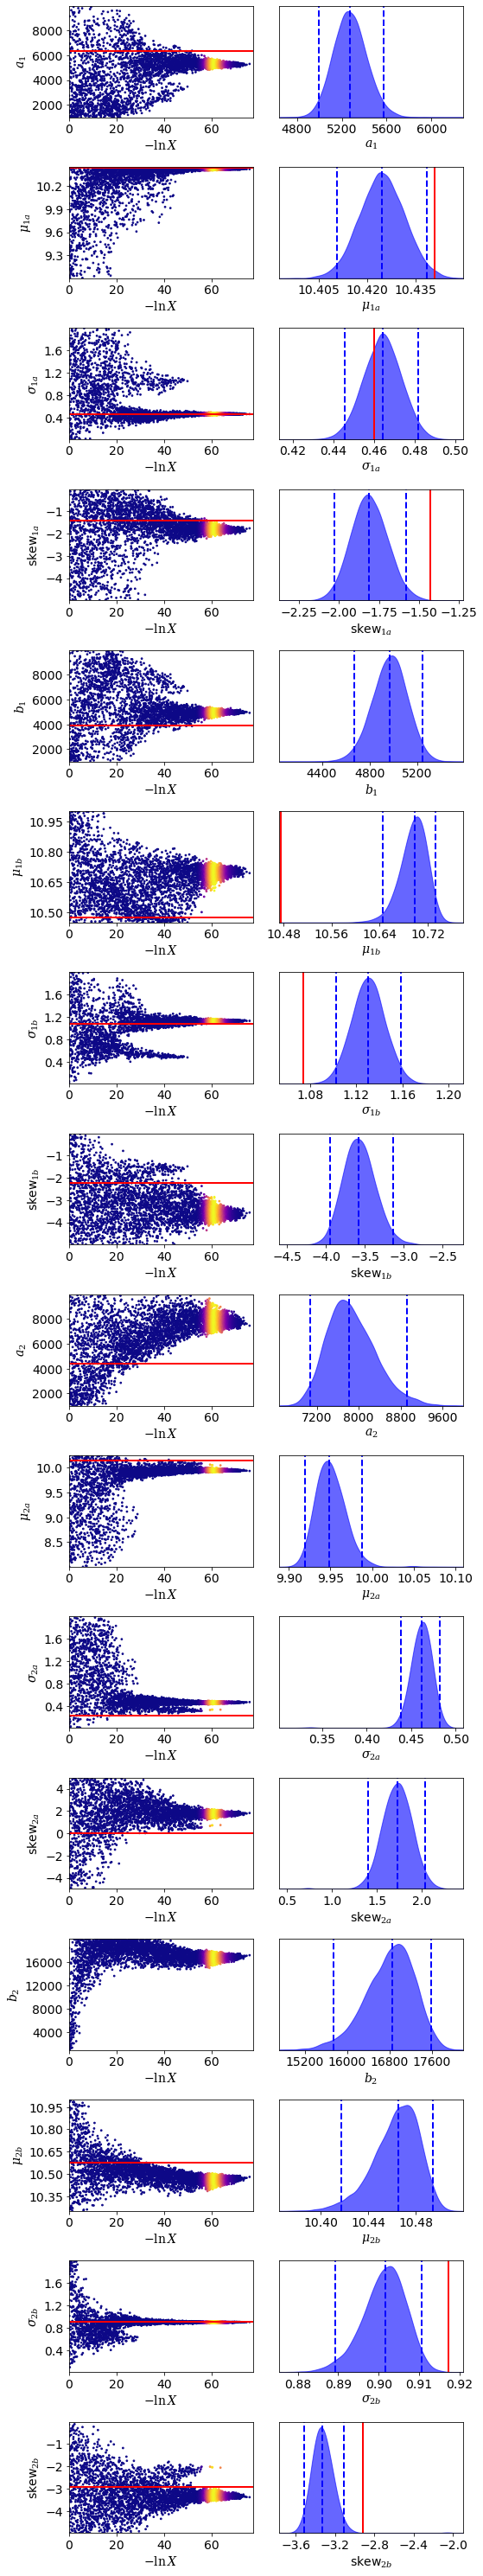

In [53]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_V2_Mstar, 
                             truths=V2_Mstar_bestfit2.x,
                             labels=labels2_bi, 
                             fig=plt.subplots(n_params, 2, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [17]:
lnzM2_V2_Mstar = dres2_V2_Mstar.logz[-1]
lnzM2_V2_Mstar

-515.2699922975067

In [55]:
V2_Mstar_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_V2_Mstar.samples, 
                                                  np.exp(dres2_V2_Mstar.logwt - lnzM2_V2_Mstar))

V2_Mstar_bestfit2_dynesty

array([ 5.27425800e+03,  1.04246524e+01,  4.63998833e-01, -1.81066684e+00,
        4.96839958e+03,  1.06961955e+01,  1.13048384e+00, -3.57266025e+00,
        7.86294752e+03,  9.95018993e+00,  4.61320294e-01,  1.72321826e+00,
        1.67975313e+04,  1.04628745e+01,  9.01265605e-01, -3.32291127e+00])

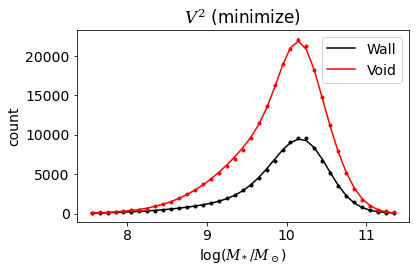

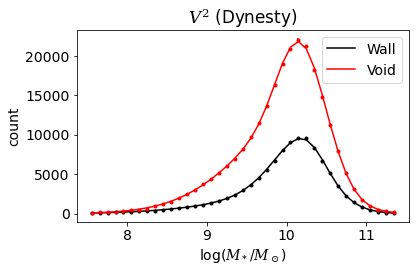

In [56]:
Model_2_plot(V2_Mstar_bestfit2.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (minimize)')

Model_2_plot(V2_Mstar_bestfit2_dynesty, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (Dynesty)')

#### VoidFinder

In [39]:
def prior_xform2_uni_VF(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(5000, 20000, u[0])
    mu_a1 = uniform(9.5, 10.25, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-2.5, 2.5, u[3])

    b1 = jeffreys(10000, 50000, u[4])
    mu_b1 = uniform(10.25, 11, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(1000, 10000, u[8])
    mu_a2 = uniform(8, 10.39, u[9])
    sigma_a2 = uniform(0.1, 2, u[10])
    skew_a2 = uniform(-10, 0, u[11])

    b2 = jeffreys(1000, 10000, u[12])
    mu_b2 = uniform(10.39, 11, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 0, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [40]:
Model_2_sampler(prior_xform2_uni_VF, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                2, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


3012it [00:37, 52.86it/s, batch: 0 | bound: 18 | nc: 25 | ncall: 48072 | eff(%):  6.201 | loglstar:   -inf < -33500.367 <    inf | logz: -33513.125 +/-  0.222 | dlogz: 23752.474 >  0.010]/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
14656it [04:19, 57.76it/s, batch: 0 | bound: 191 | nc: 25 | ncall: 347796 | eff(%):  4.208 | loglstar:   -inf < -868.334 <    inf | logz: -901.844 +/-  0.361 | dlogz: 278.599 >  0.010]    /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random wal

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_VoidFinder'


In [41]:
#temp_infile = open('dynesty_output/sampler_results_model2_gauss_Mstar_VoidFinder.pickle', 
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_VoidFinder.pickle', 
                   'rb')
dres2_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

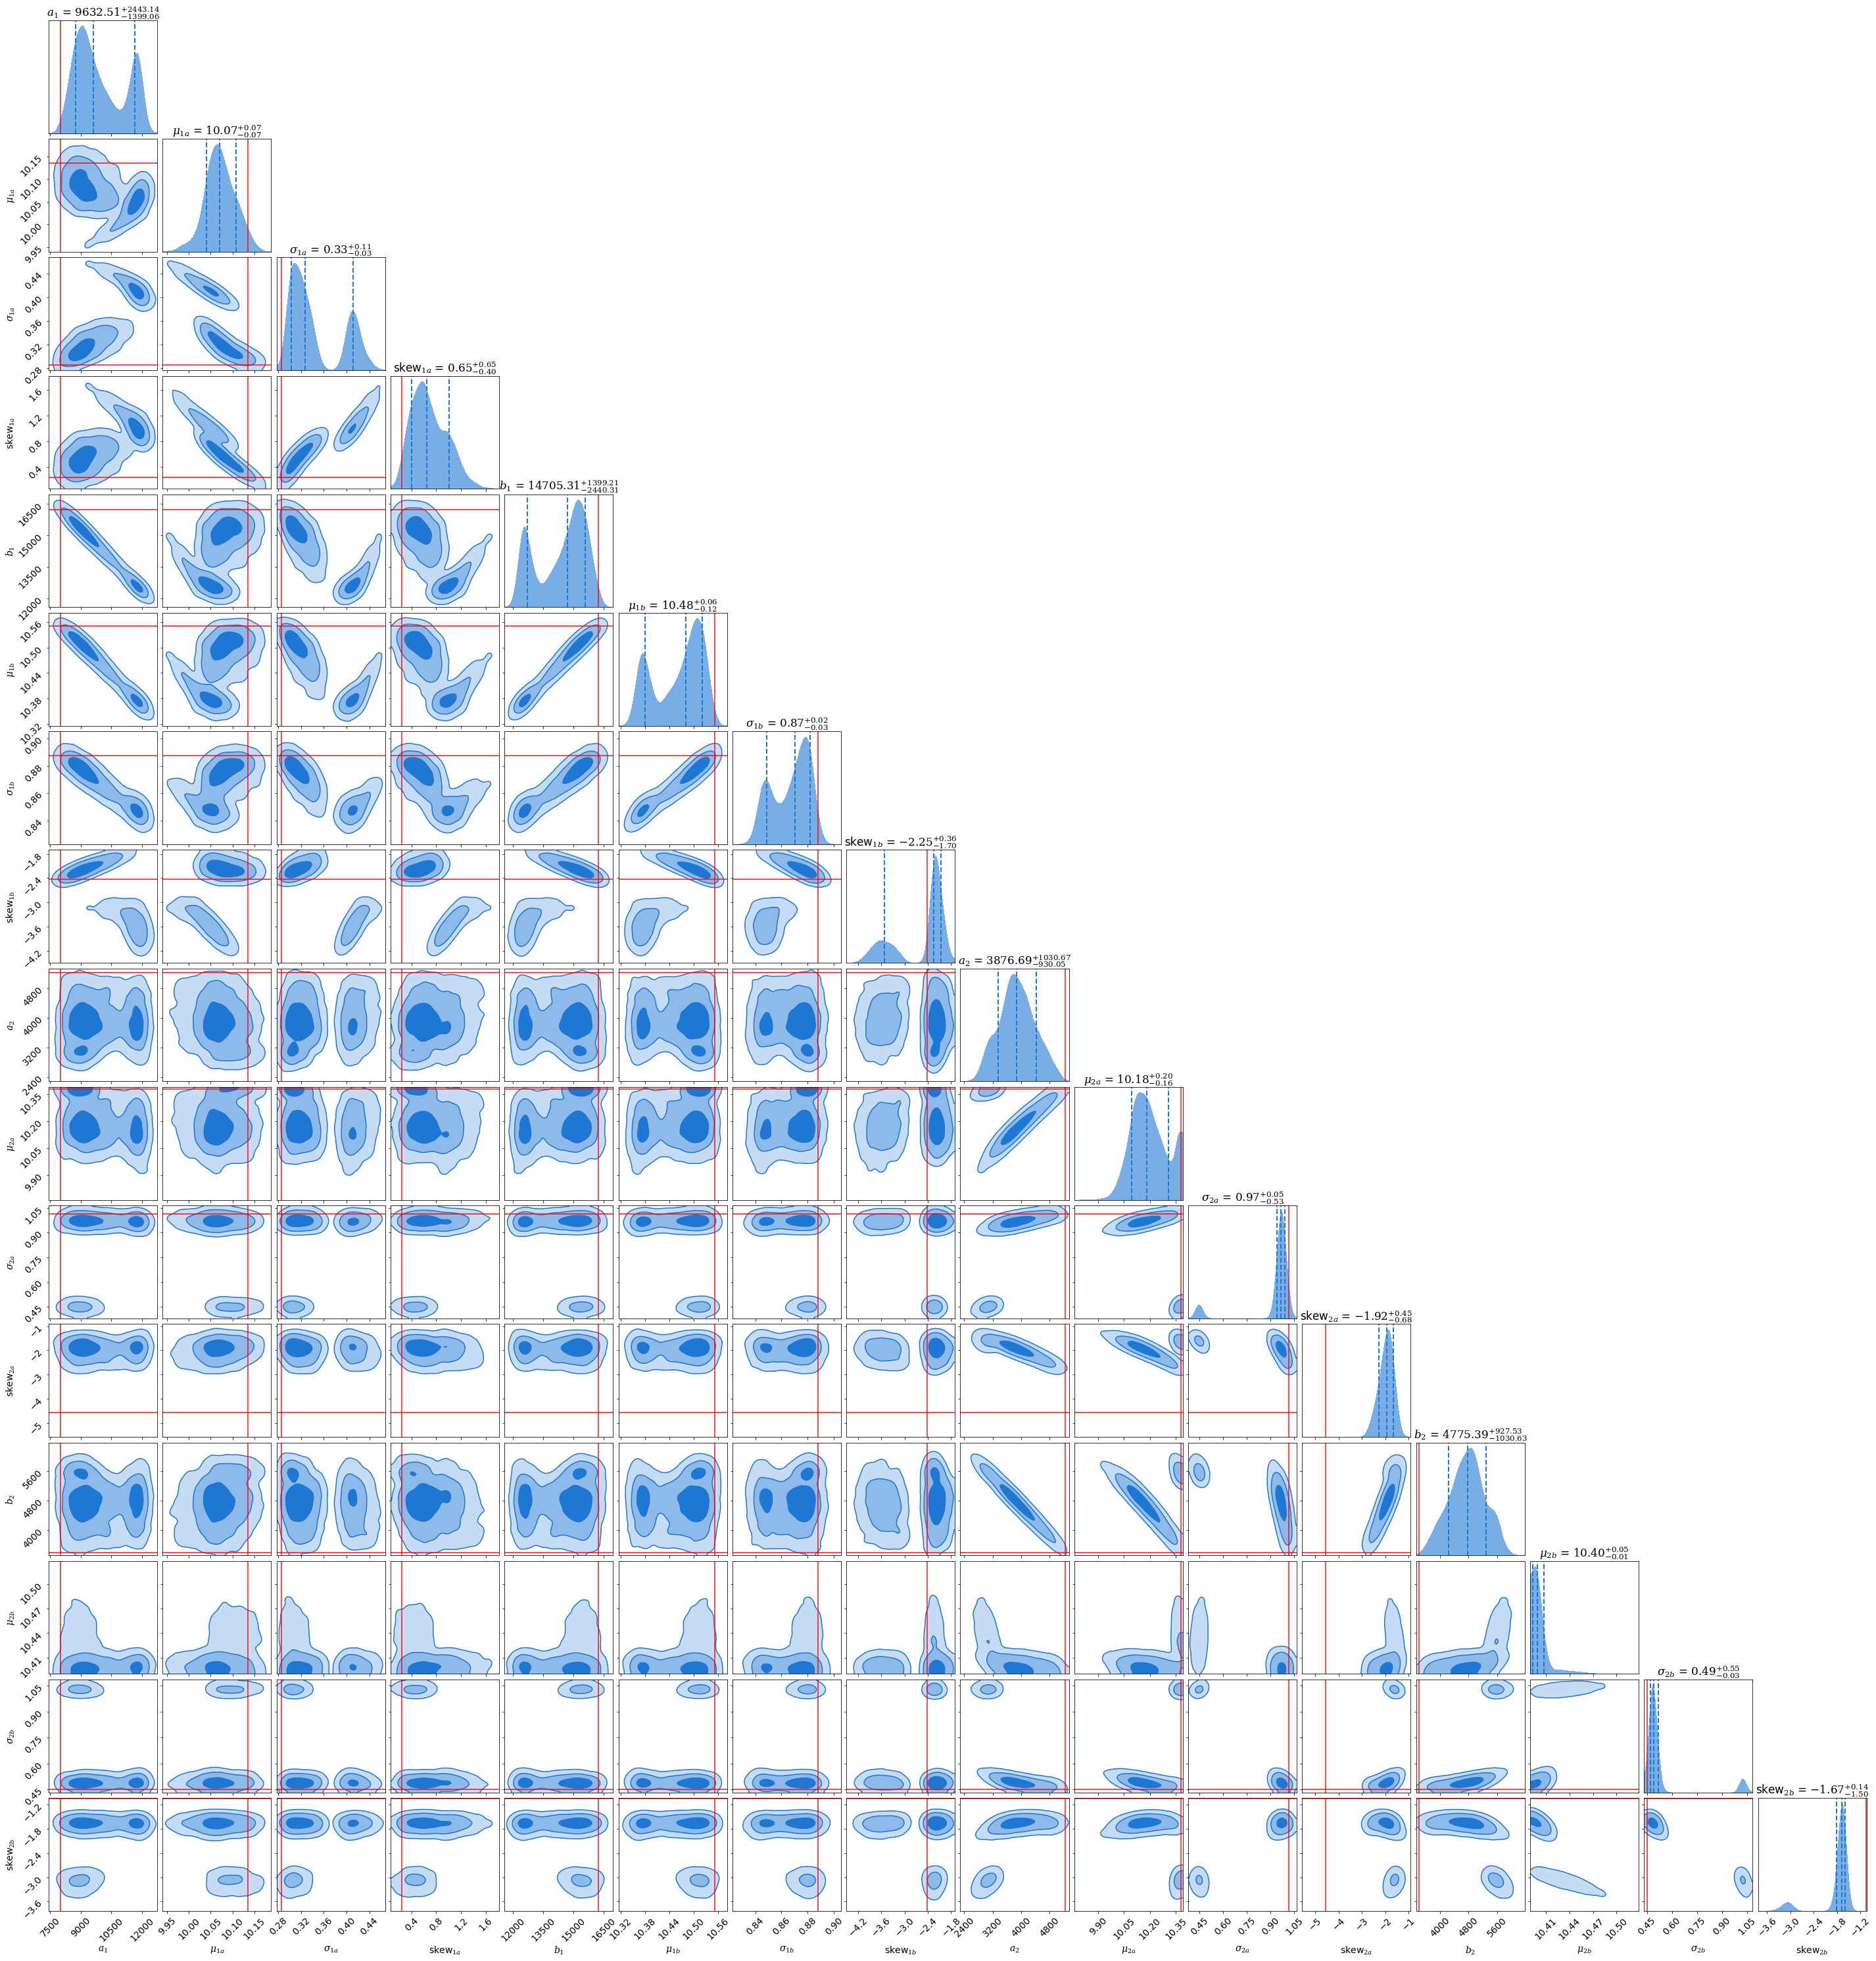

In [42]:
fig, axes = dyplot.cornerplot(dres2_VF_Mstar, smooth=0.03, 
                              labels=labels2_bi,
                              #labels=labels2_uni, 
                              truths=[*VF_Mstar_bestfit2.x[4:8], 
                                      *VF_Mstar_bestfit2.x[:4], 
                                      *VF_Mstar_bestfit2.x[12:], 
                                      *VF_Mstar_bestfit2.x[8:12]],
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(16, 16, figsize=(2.5*16, 2.6*16)),
                              #fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

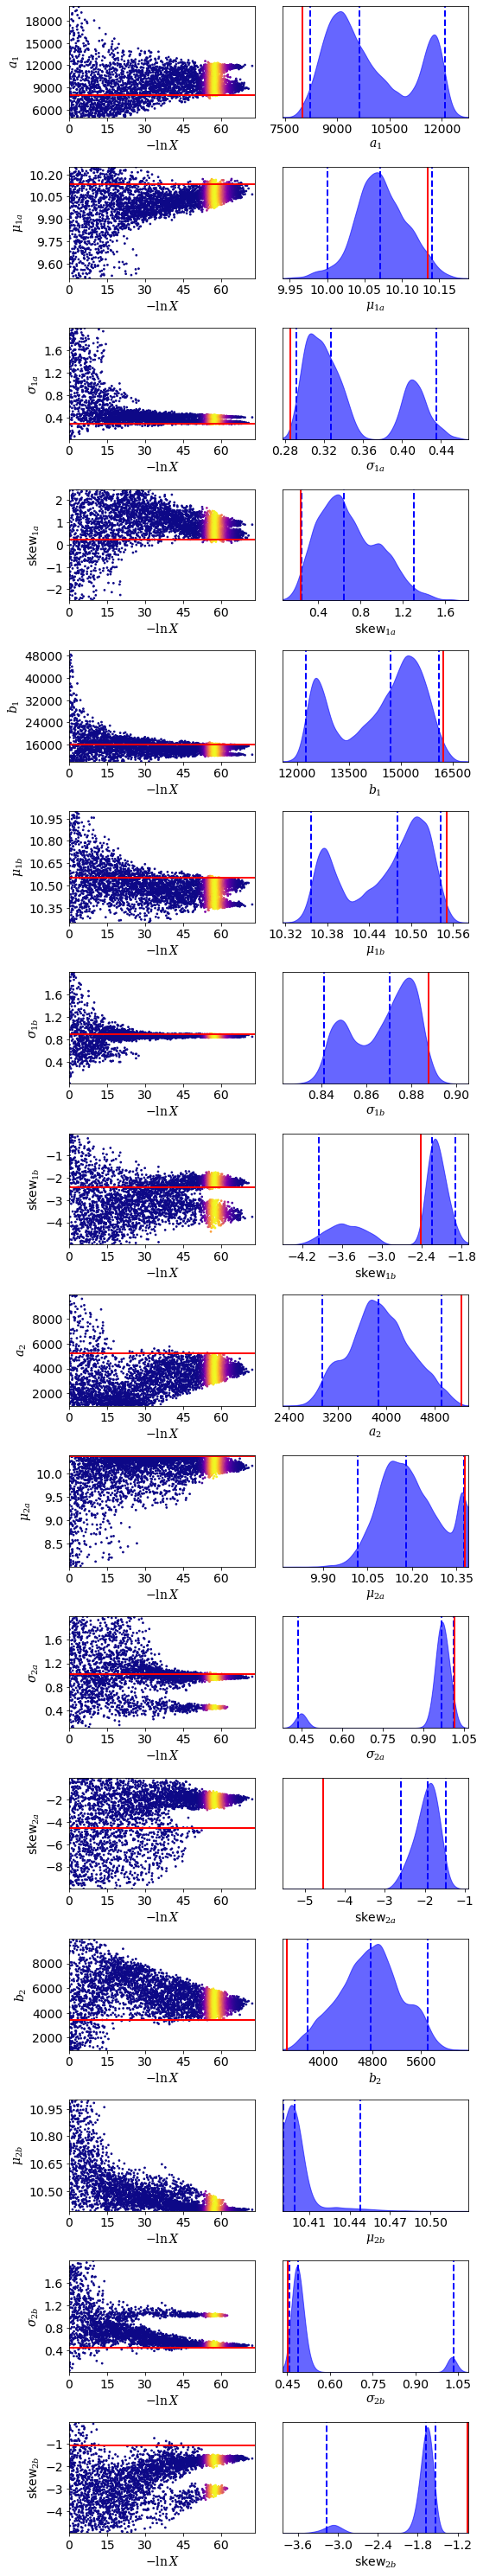

In [43]:
n_params = len(labels2_bi)

fig, axes = dyplot.traceplot(dres2_VF_Mstar, 
                             labels=labels2_bi, 
                             truths=[*VF_Mstar_bestfit2.x[4:8], 
                                      *VF_Mstar_bestfit2.x[:4], 
                                      *VF_Mstar_bestfit2.x[12:], 
                                      *VF_Mstar_bestfit2.x[8:12]], 
                             fig=plt.subplots(n_params, 2, figsize=(8, 2.6*n_params)), 
                             thin=10)

fig.tight_layout();

In [44]:
lnzM2_VF_Mstar = dres2_VF_Mstar.logz[-1]
lnzM2_VF_Mstar

-507.34434077397344

In [45]:
VF_Mstar_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_VF_Mstar.samples, 
                                                  np.exp(dres2_VF_Mstar.logwt - lnzM2_VF_Mstar))

VF_Mstar_bestfit2_dynesty

array([ 9.97585009e+03,  1.00722519e+01,  3.45886541e-01,  6.93220780e-01,
        1.43604908e+04,  1.04619416e+01,  8.66982293e-01, -2.57214524e+00,
        3.89162853e+03,  1.01919864e+01,  9.19245780e-01, -1.95960493e+00,
        4.76082804e+03,  1.04026585e+01,  5.41237843e-01, -1.81129313e+00])

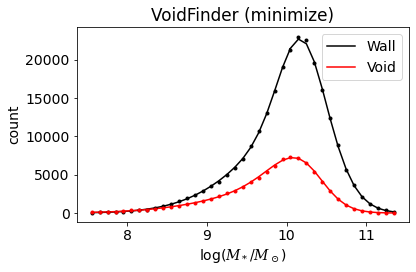

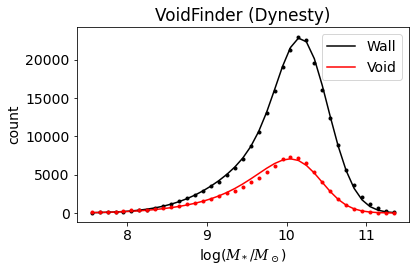

In [46]:
Model_2_plot(VF_Mstar_bestfit2.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (minimize)')

Model_2_plot(VF_Mstar_bestfit2_dynesty, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             2, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [20]:
lnB12_V2_Mstar = lnzM1_V2_Mstar - lnzM2_V2_Mstar

B12_V2_Mstar = np.exp(lnB12_V2_Mstar)

#print('V2 Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_Mstar, np.log10(B12_V2_Mstar)))
print('V2 Mstar: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_V2_Mstar, lnB12_V2_Mstar*np.log10(np.exp(1))))

V2 Mstar: B12 = 4.73e-204; log(B12) = -203.325


In [47]:
lnB12_VF_Mstar = lnzM1_VF_Mstar - lnzM2_VF_Mstar

B12_VF_Mstar = np.exp(lnB12_VF_Mstar)

#print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_VF_Mstar, np.log10(B12_VF_Mstar)))
print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_Mstar, lnB12_VF_Mstar*np.log10(np.exp(1))))

VoidFinder Mstar: B12 = 0; log(B12) = -1627.084


Both VoidFinder and V$^2$ overwhelmingly favor model $\mathcal{M}_2$, in which the two data sets come from different parent distributions.